In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/MLTSA22

/content/drive/MyDrive/MLTSA22


In [ ]:
mkdir final_graphics

In [ ]:
cd final_graphics/

/content/drive/MyDrive/MLTSA22/final_graphics


In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 1.2 MB/s 
     |████████████████████████████████| 49 kB 1.7 MB/s 
     |████████████████████████████████| 45 kB 2.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640289 sha256=bb5ccf9a0334f7c3655f78cda904b04da3808cfd27028c4d600944d92bbe3104
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
import numpy as np
import pylab as pl
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet import diagnostics
from scipy import stats
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
pl.style.use('seaborn')

In [ ]:
suez = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/original_data/suez.csv')
longbeach = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/original_data/longbeach.csv')
rotterdam = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/original_data/rotterdam.csv')
singapore = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/original_data/singapore.csv')
bayonne = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/original_data/bayonne.csv')

In [ ]:
allDFs = [suez, longbeach, rotterdam, singapore, bayonne]
names = ["Suez Canal", "Long Beach", "Rotterdam", "Singapore", "Bayonne"]

In [ ]:
covid = pd.read_csv('https://raw.githubusercontent.com/lifewinning/MLTSA22_final/main/data/WHO-COVID-19-global-data.csv')

In [ ]:
covid['Date_reported'] = pd.to_datetime(covid.Date_reported)
covid.rename(columns = {'Date_reported':'ds'}, inplace = True)
daily_covid = covid.groupby('ds')[['New_cases']].sum().reset_index()
daily_covid = daily_covid[daily_covid['ds'] <= '2021-12-31']
daily_covid['New_cases'] = preprocessing.scale(daily_covid['New_cases'])

In [ ]:
import datetime

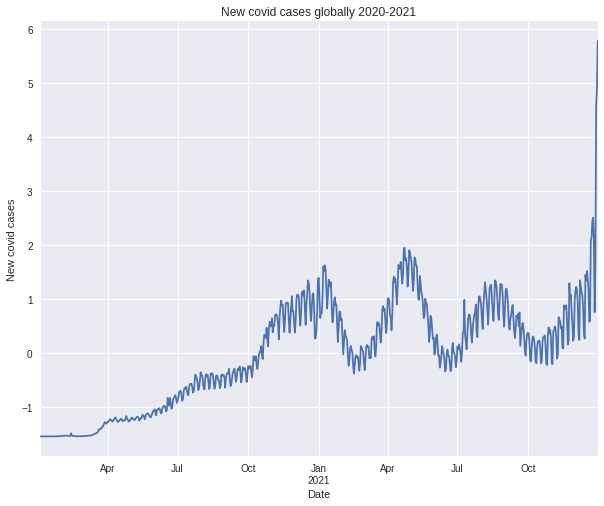

In [ ]:
fig, ax = pl.subplots(figsize=(10, 8))
daily_covid.plot('ds', 'New_cases', ax=ax, legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('New covid cases')
ax.set_title('New covid cases globally 2020-2021')
pl.savefig('covid_total.png')

In [ ]:
dc_idx = daily_covid
dc_idx.index = dc_idx.ds

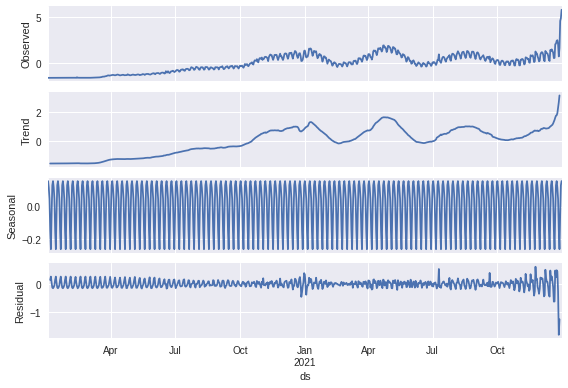

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(dc_idx['New_cases'])
 
components.plot();

In [ ]:
dates = pd.date_range(start = '1/1/2018', end = '1/2/2020')

In [ ]:
newdf = pd.DataFrame(data=dates, columns=['ds'])

In [ ]:
covid_backfill = pd.concat([newdf, daily_covid]).fillna(daily_covid.New_cases.min())

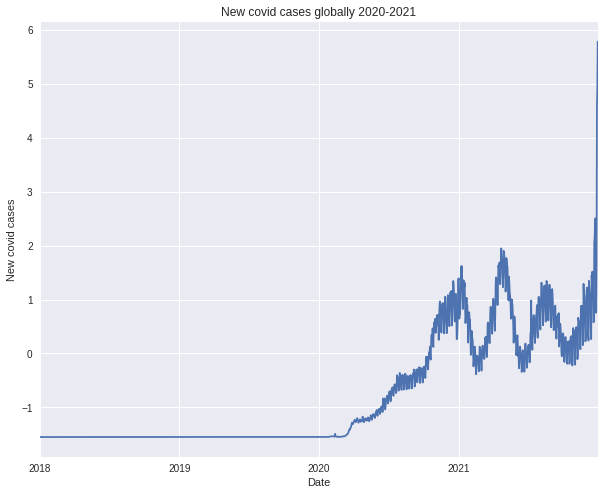

In [ ]:
fig, ax = pl.subplots(figsize=(10, 8))
covid_backfill.plot('ds', 'New_cases', ax=ax, legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('New covid cases')
ax.set_title('New covid cases globally 2020-2021')
pl.savefig('covid_backfill.png')

In [ ]:
def shapeDFs(df):
  newdf = df.drop(columns = df.columns[0])
  newdf.rename(columns = {'date':'ds'}, inplace=True)
  newdf['ds'] = pd.to_datetime(newdf.ds)
  newdf['y'] = preprocessing.scale(newdf.y)
  newdf['y_err'] = preprocessing.scale(newdf.y_err)
  return newdf

In [ ]:
def covidMerge(df):
  mergeDF = pd.merge(df, daily_covid,  on= 'ds', how = 'left')
  mergeDF['New_cases'] =  mergeDF['New_cases'].fillna(daily_covid.New_cases.min())
  return mergeDF

In [323]:
def covidMerge_bf(df):
  mergeDF = pd.merge(covid_backfill, df,  on= 'ds', how = 'left')
  # mergeDF['y'] = mergeDF['y'].fillna(method='bfill')
  return mergeDF

In [ ]:
def makeProphetSimple(df):
  model = Prophet().fit(df[['ds','y']])
  pred = model.predict(df[['ds','y']])
  return model, pred

In [ ]:
def makeProphetCovid(df): 
  model = Prophet().add_regressor('New_cases').fit(df)
  pred = model.predict(df)
  return model, pred

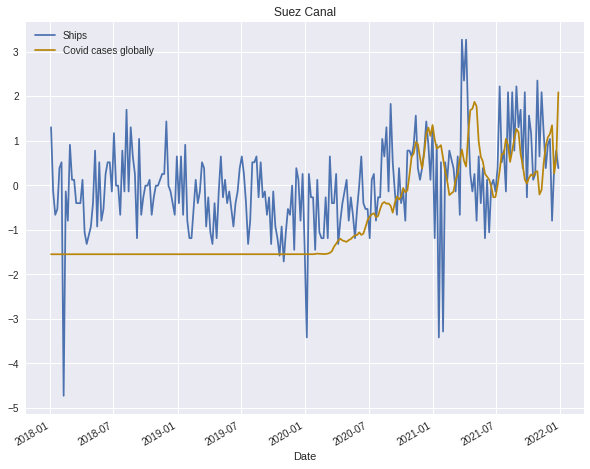

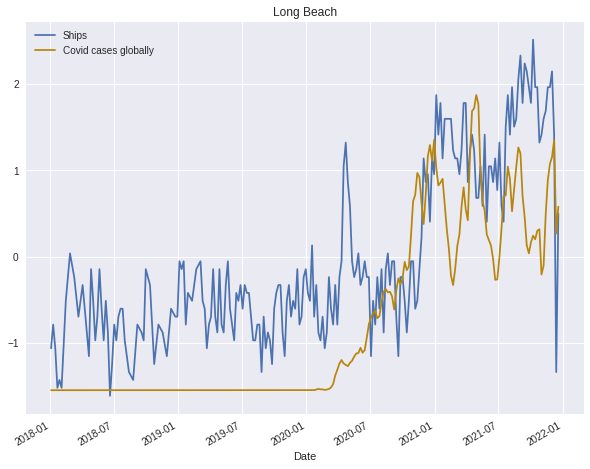

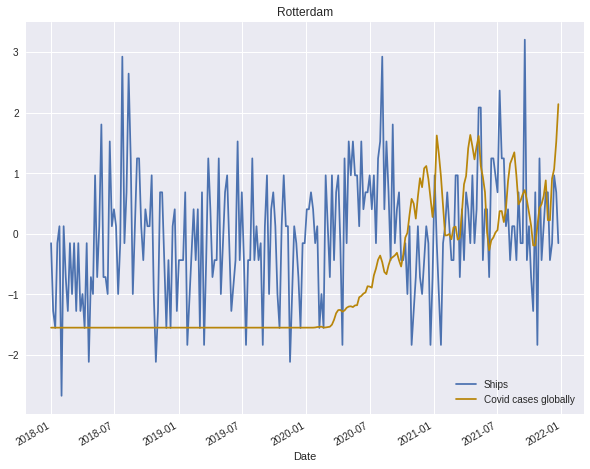

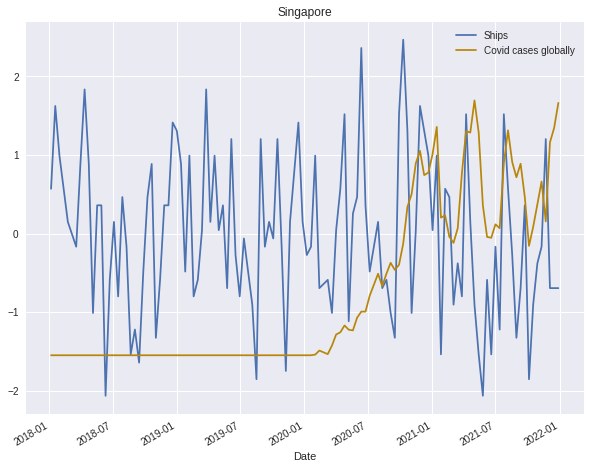

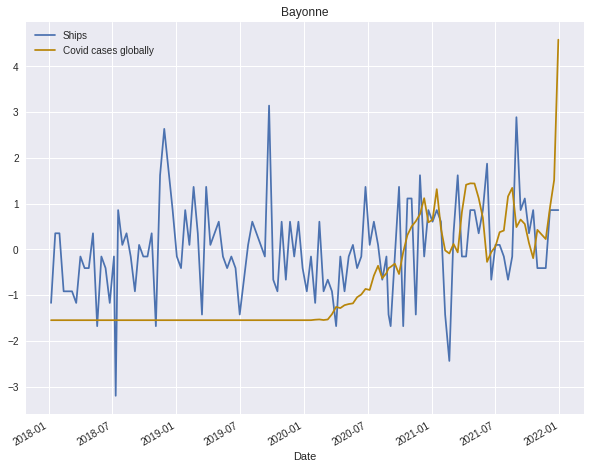

In [324]:
for i,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  covidDF = covidMerge(basicDF)
  fig, ax = pl.subplots(figsize=(10, 8))
  covidDF.plot('ds', 'y', ax=ax, label = 'Ships')
  covidDF.plot('ds', 'New_cases', ax=ax, label='Covid cases globally', color='darkgoldenrod')
  ax.set_xlabel('Date')
  ax.set_title(names[i])
  pl.savefig(names[i]+"_covid.png")

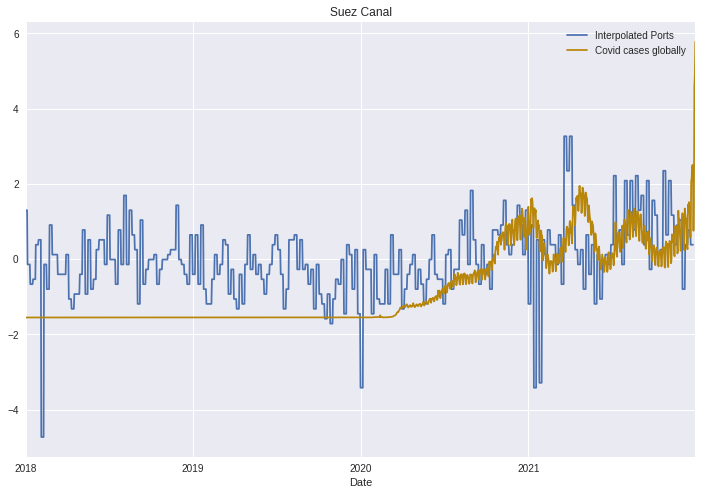

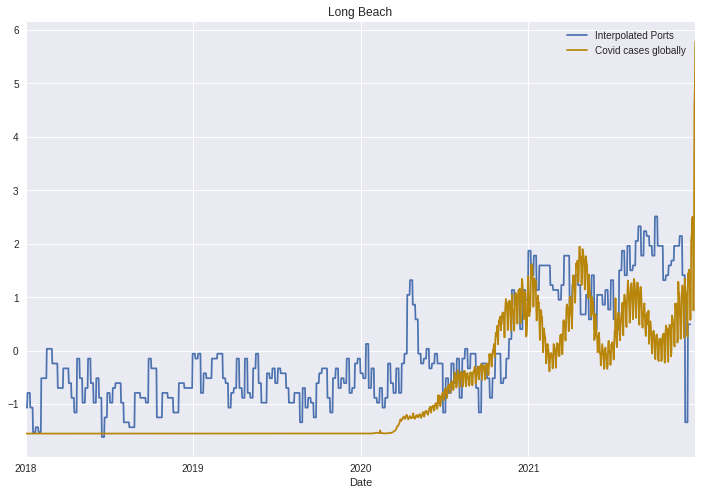

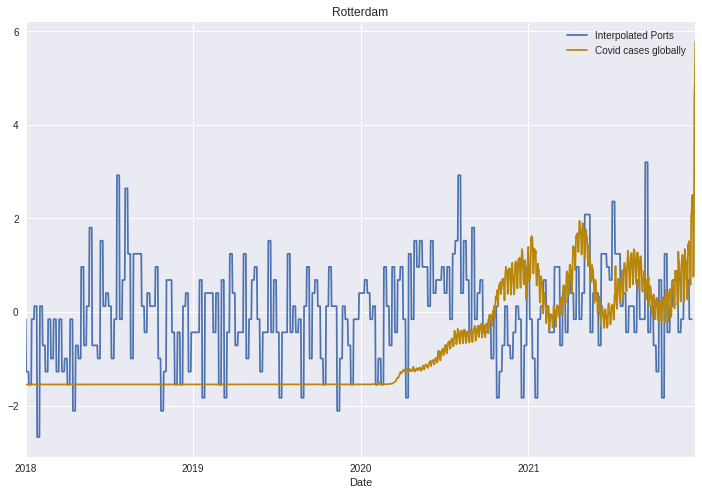

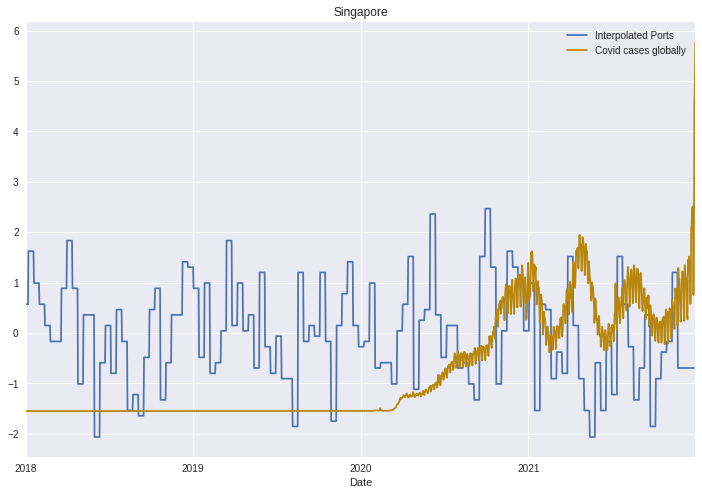

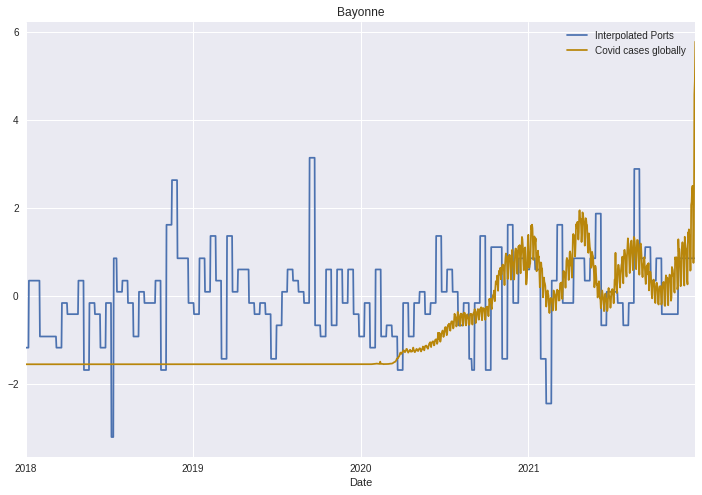

In [325]:
for i,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  covidDF = covidMerge_bf(basicDF)
  fig, ax = pl.subplots(figsize=(12, 8))
  covidDF.plot('ds', 'y', ax=ax, label = 'Interpolated Ports')
  covidDF.plot('ds', 'New_cases', ax=ax, label='Covid cases globally', color='darkgoldenrod')
  ax.set_xlabel('Date')
  ax.set_title(names[i])
  pl.savefig(names[i]+"_interpolated_covid.png")

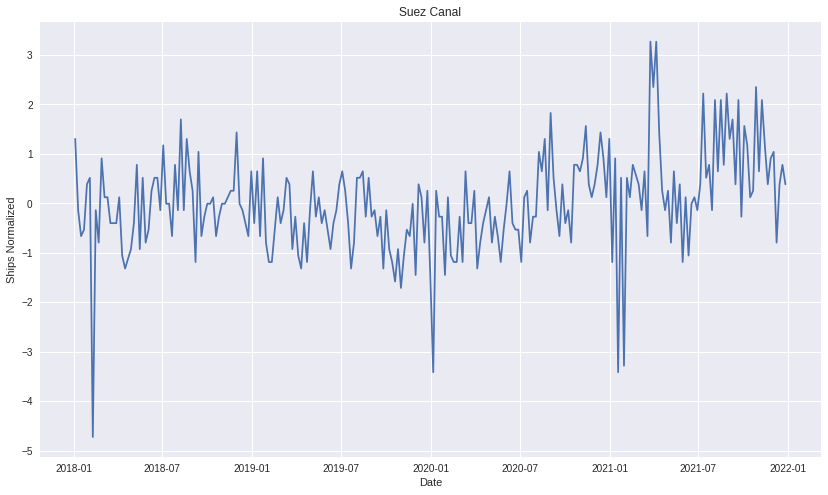

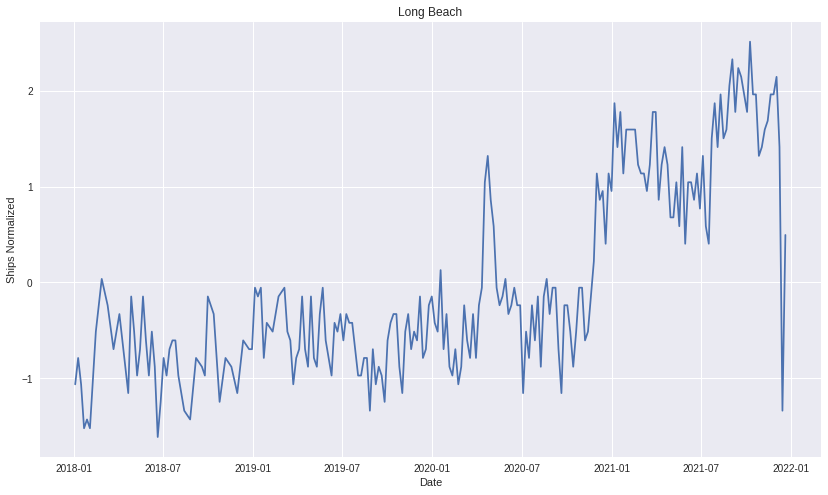

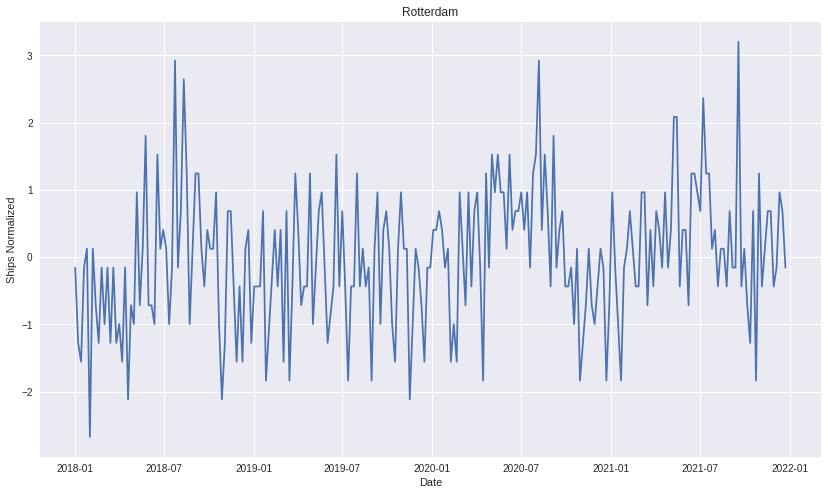

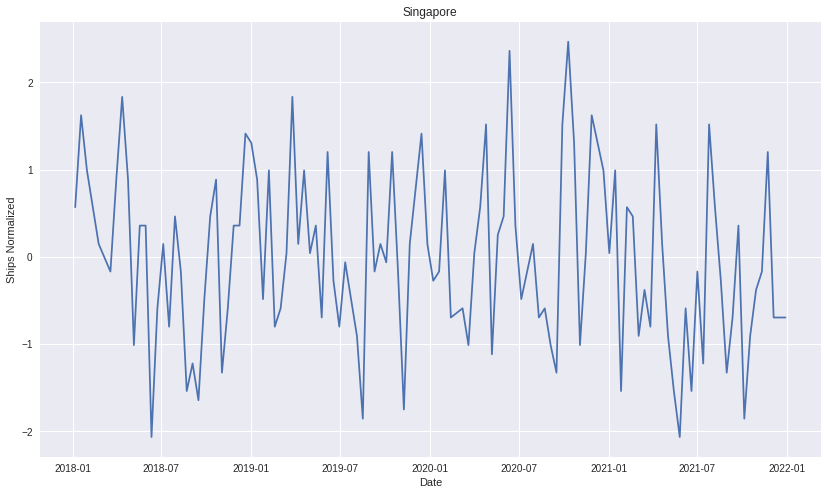

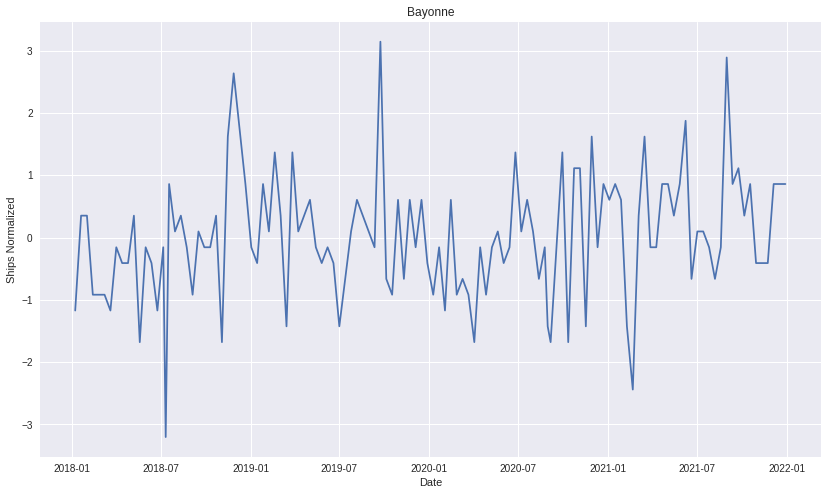

In [ ]:
for i ,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  fig, ax = pl.subplots(figsize=(14, 8))
  ax.plot(basicDF['ds'], basicDF['y'])
  # ax.errorbar(basicDF['ds'], basicDF['y'],yerr=basicDF['y_err'], fmt='o')
  ax.set_xlabel('Date')
  ax.set_ylabel('Ships Normalized')
  ax.set_title('{0}'.format(names[i]))
  pl.savefig(names[i]+'_ships.png')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

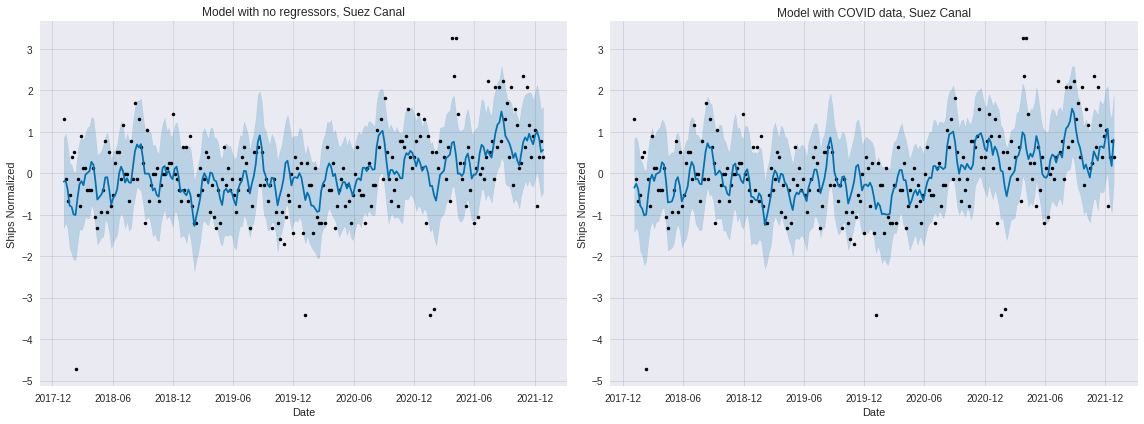

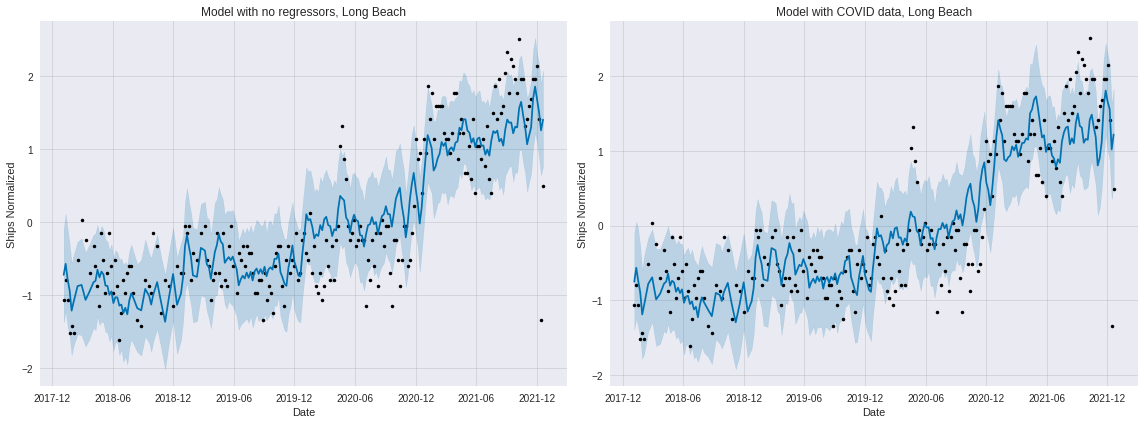

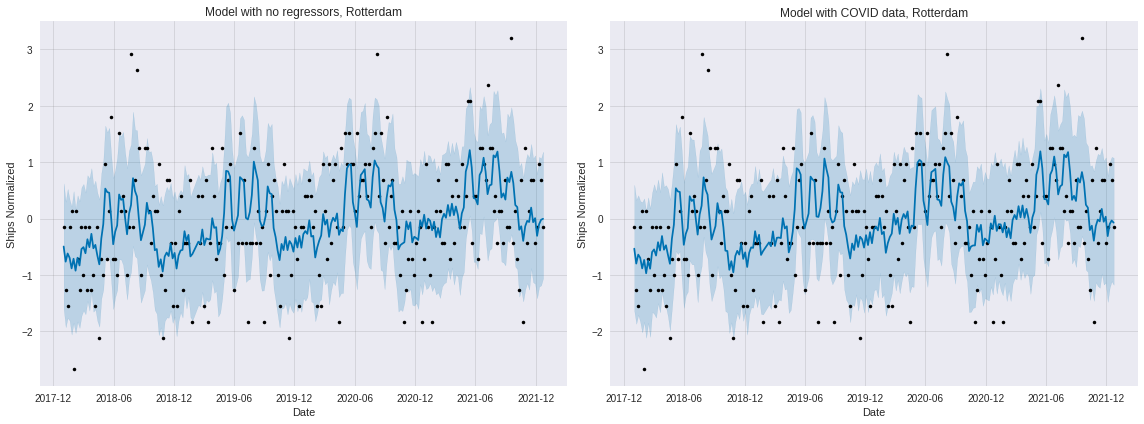

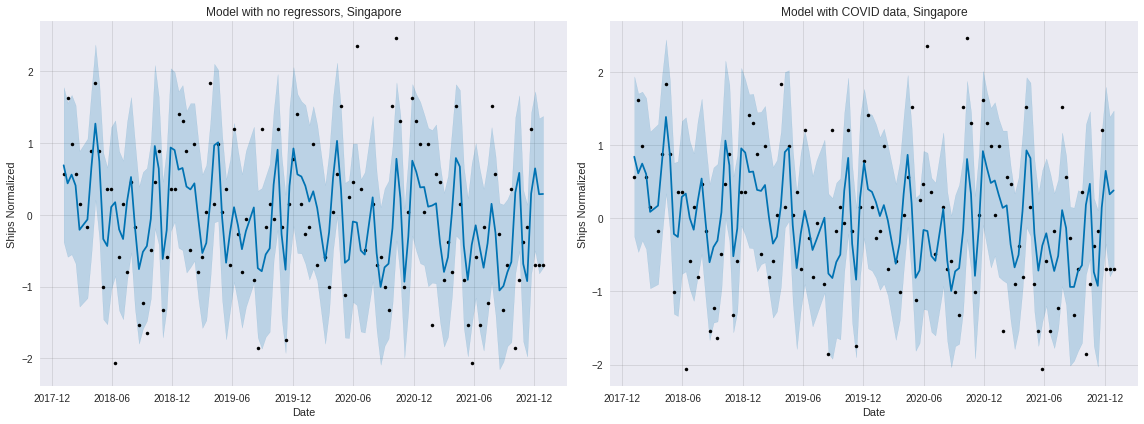

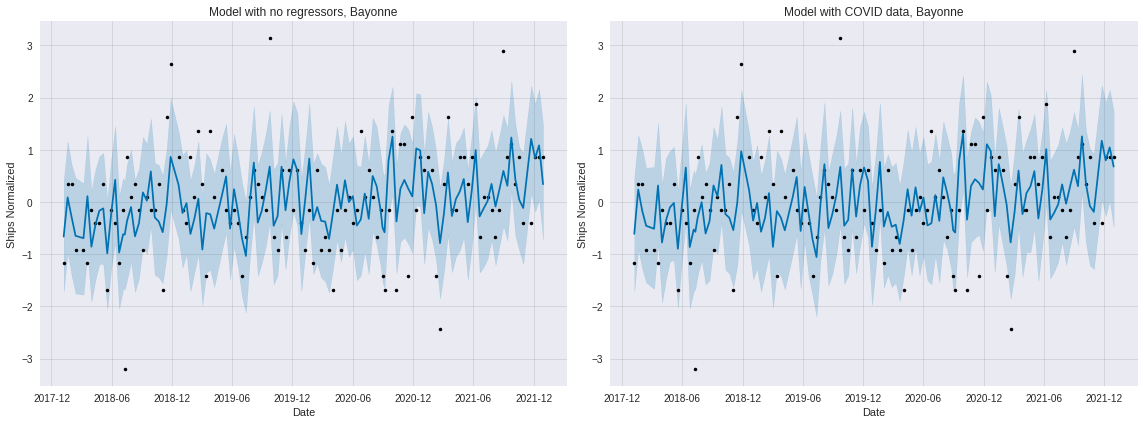

In [330]:
for i,df in enumerate(allDFs):
  fig, ax = pl.subplots(1, 2, figsize=(16, 6))
  basicDF = shapeDFs(df)
  basicModel, basicPred = makeProphetSimple(basicDF)
  covidDF = covidMerge(basicDF)
  covidModel, covidPred = makeProphetCovid(covidDF)
  basicModel.plot(basicPred, ax=ax[0])
  ax[0].set_xlabel('Date')
  ax[0].set_ylabel('Ships Normalized')
  ax[0].set_title('Model with no regressors, {0}'.format(names[i]))
  covidModel.plot(covidPred, ax=ax[1]);
  ax[1].set_xlabel('Date')
  ax[1].set_ylabel('Ships Normalized')
  ax[1].set_title('Model with COVID data, {0}'.format(names[i]))
  pl.savefig(names[i]+'_models.png')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

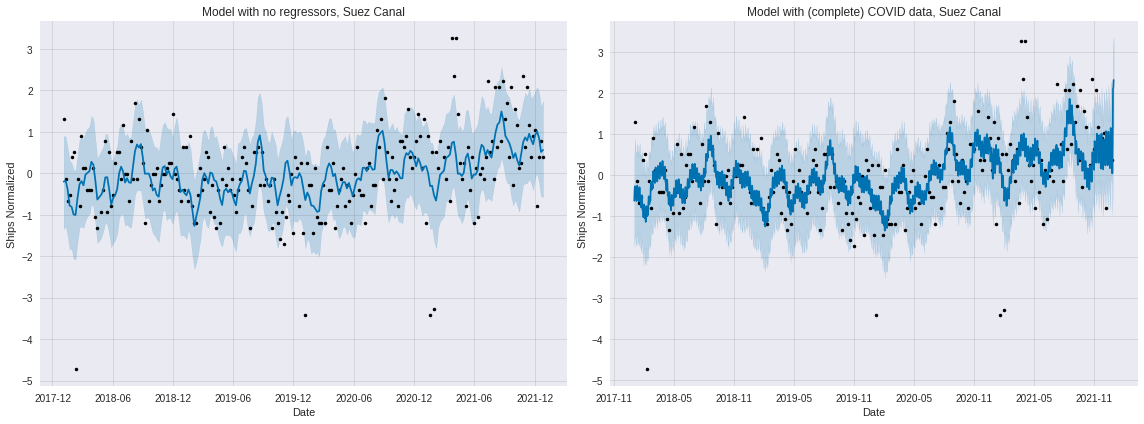

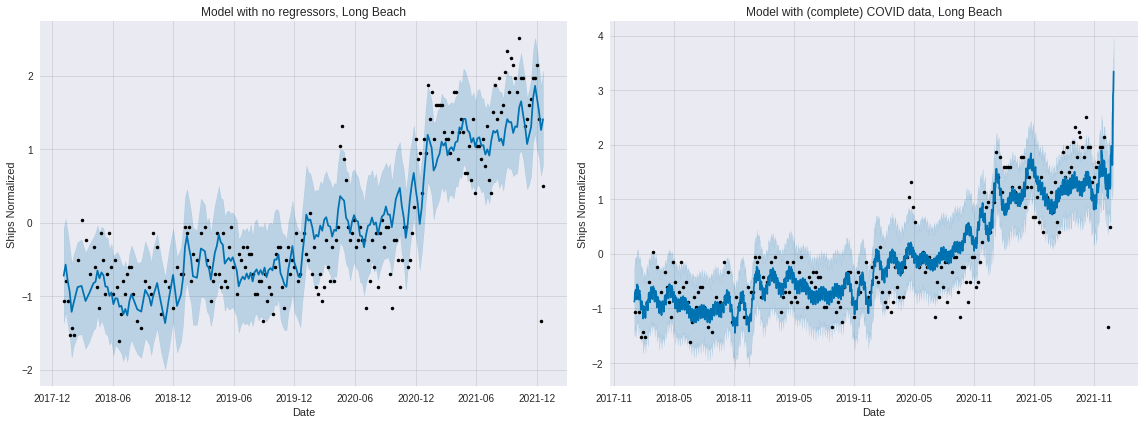

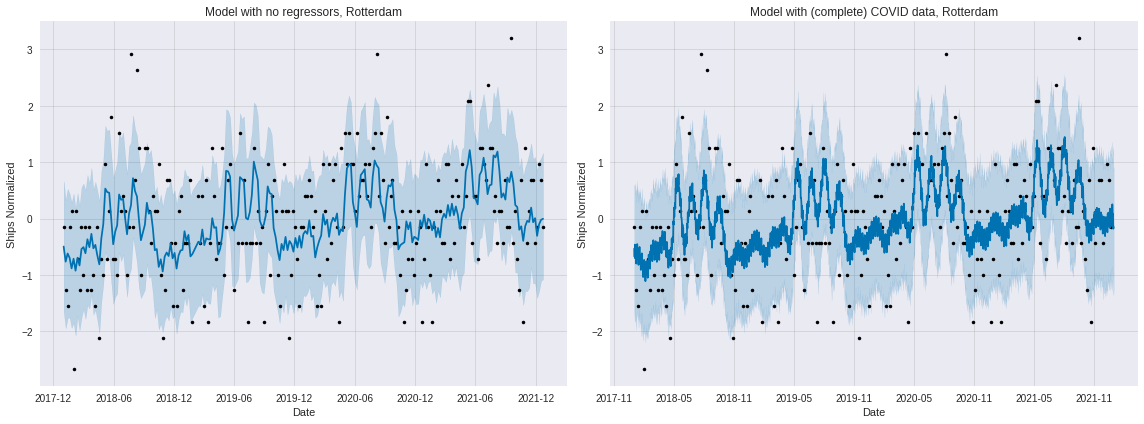

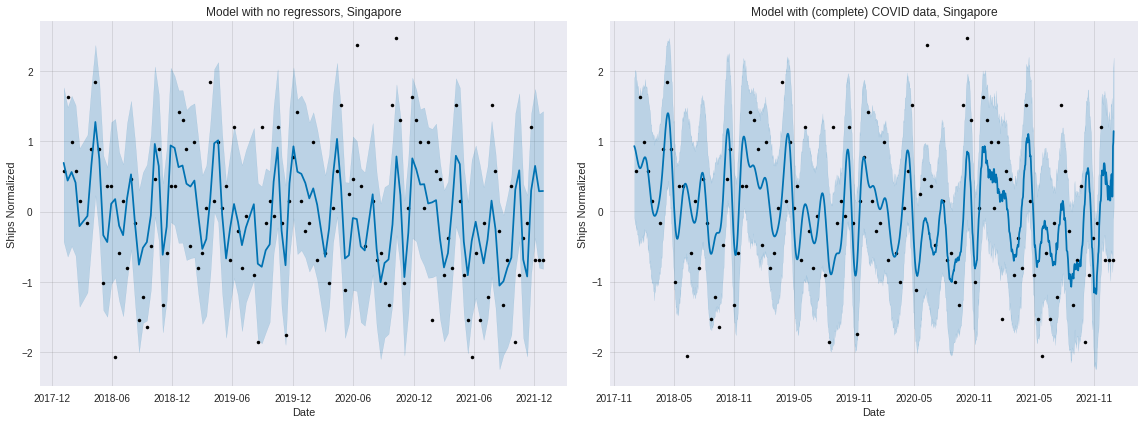

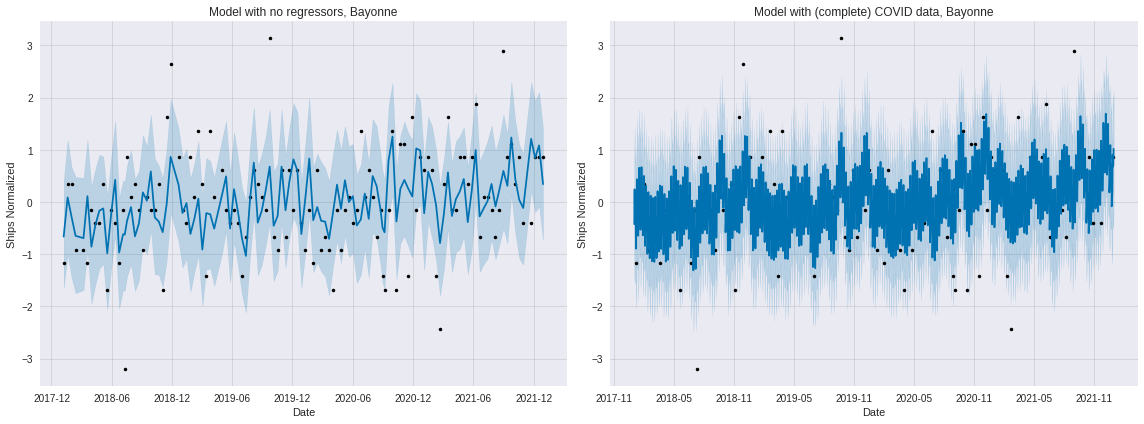

In [ ]:
for i,df in enumerate(allDFs):
  fig, ax = pl.subplots(1, 2, figsize=(16, 6))
  basicDF = shapeDFs(df)
  basicModel, basicPred = makeProphetSimple(basicDF)
  covidDF = covidMerge_bf(basicDF)
  covidModel, covidPred = makeProphetCovid(covidDF)
  basicModel.plot(basicPred, ax=ax[0])
  ax[0].set_xlabel('Date')
  ax[0].set_ylabel('Ships Normalized')
  ax[0].set_title('Model with no regressors, {0}'.format(names[i]))
  covidModel.plot(covidPred, ax=ax[1]);
  ax[1].set_xlabel('Date')
  ax[1].set_ylabel('Ships Normalized')
  ax[1].set_title('Model with (complete) COVID data, {0}'.format(names[i]))
  pl.savefig(names[i]+'_imputed_models.png')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

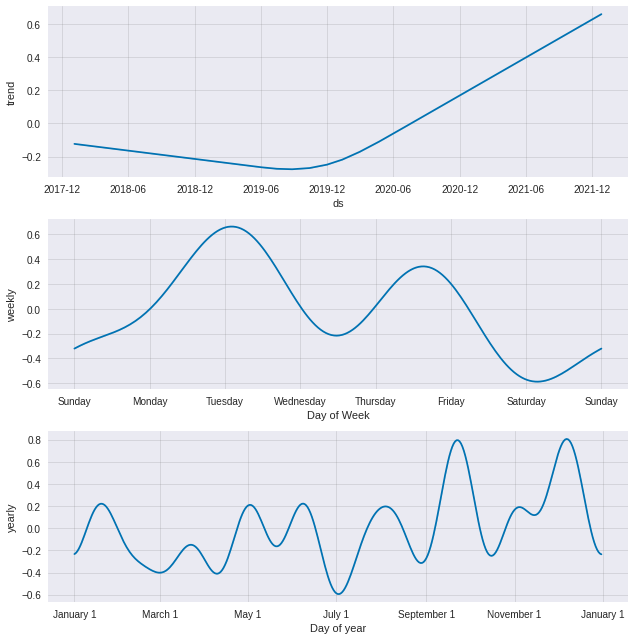

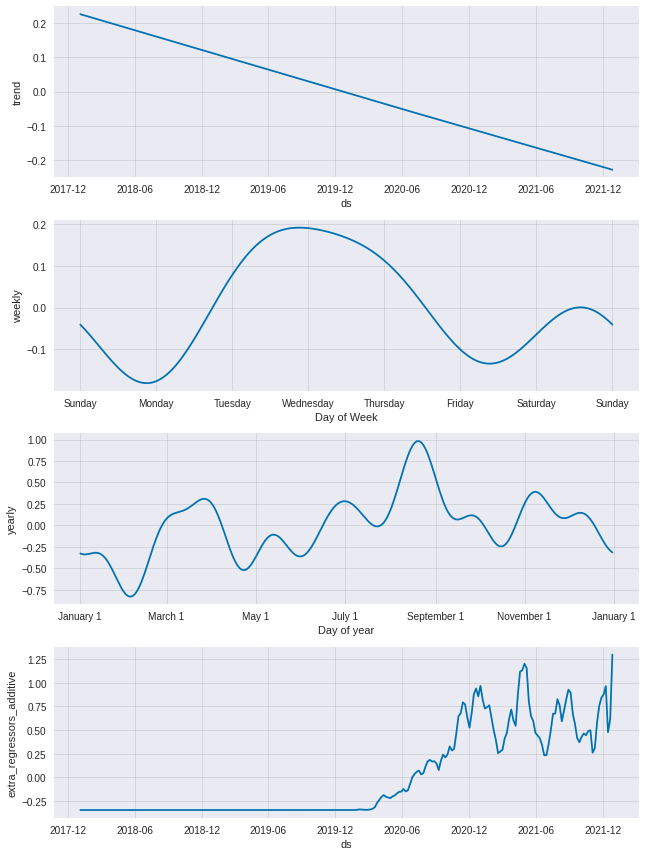

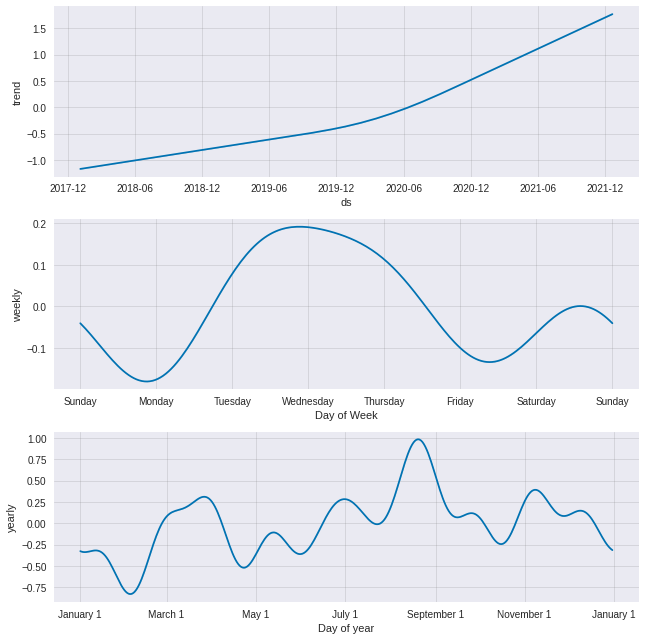

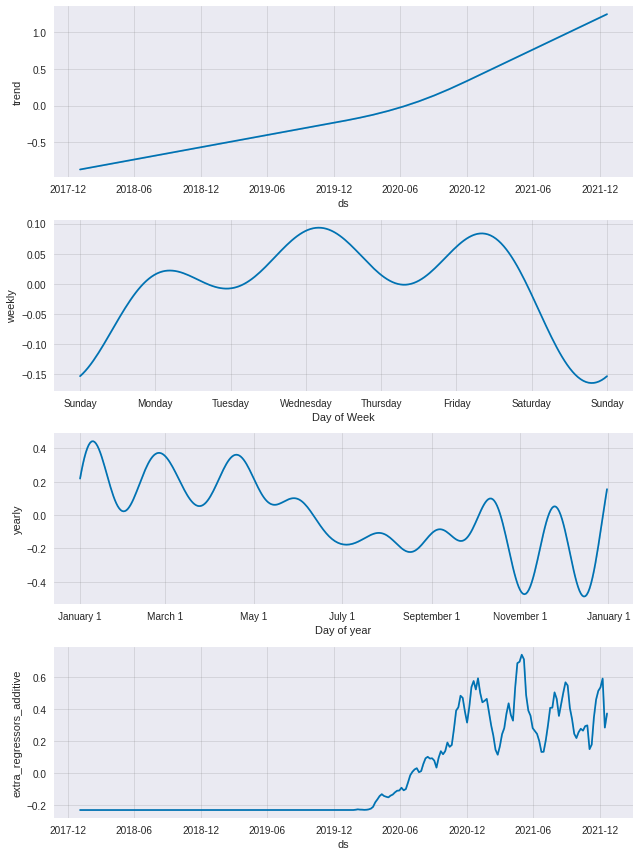

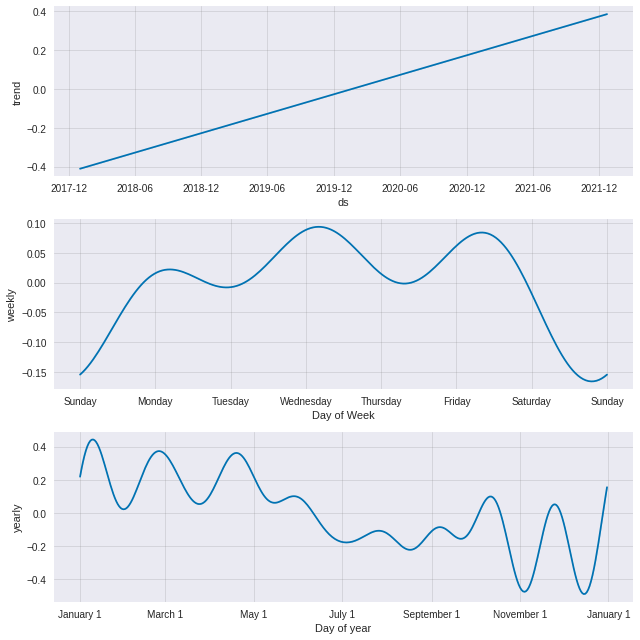

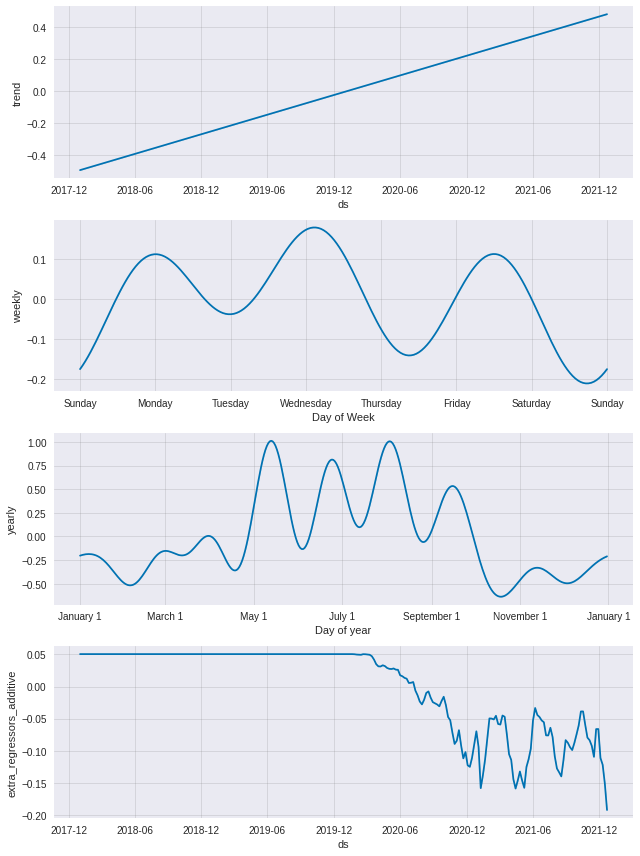

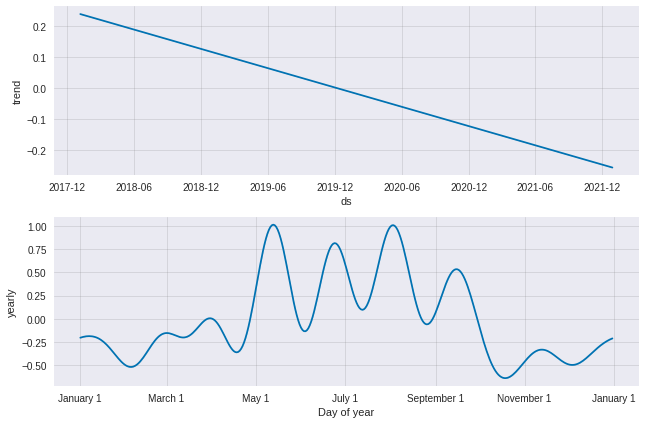

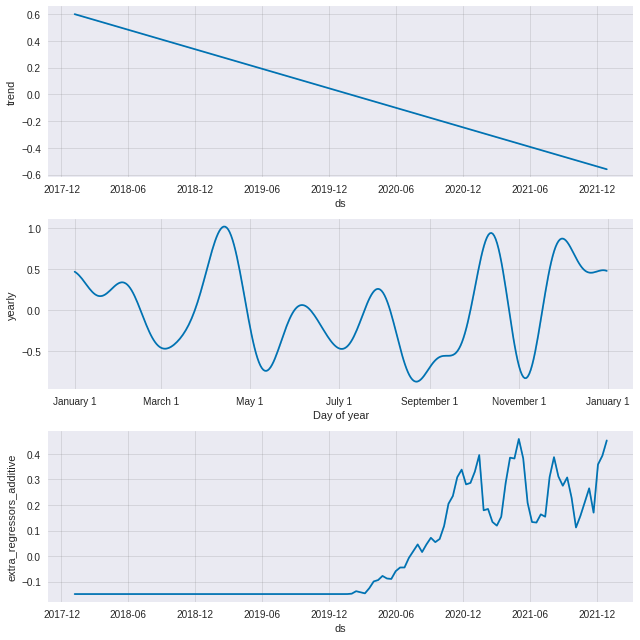

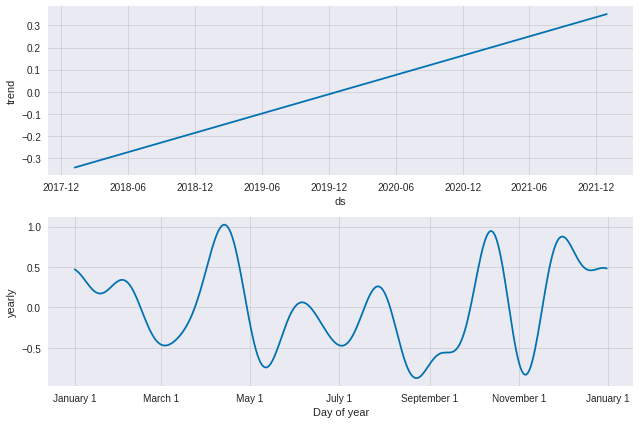

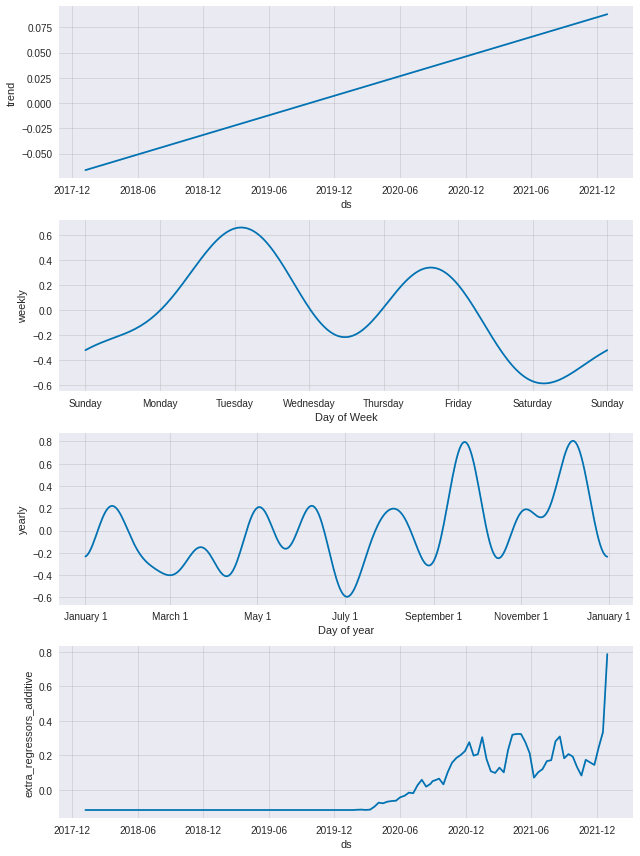

In [ ]:
for i,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  basicModel, basicPred = makeProphetSimple(basicDF)
  covidDF = covidMerge(basicDF)
  covidModel.plot_components(basicPred)
  pl.savefig(names[i]+'_simple_components.png')
  covidModel, covidPred = makeProphetCovid(covidDF)
  covidModel.plot_components(covidPred)
  pl.savefig(names[i]+'_covid_components.png')


In [ ]:
def rchi2(y, ytrue):
  return np.sum(((ytrue-y)**2)/len(ytrue))

In [ ]:
def cv_rchi2(model):
  cv = diagnostics.cross_validation(model, horizon ='180 days')
  return rchi2(cv['yhat'], cv['y'])

In [ ]:
simpleRchi, covidRchi = [], []

for i,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  basicModel, basicPred = makeProphetSimple(basicDF)
  covidDF = covidMerge(basicDF)
  covidModel, covidPred = makeProphetCovid(covidDF)
  simpleRchi.append(cv_rchi2(basicModel))
  covidRchi.append(cv_rchi2(covidModel))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-10 00:00:00 and 2021-06-29 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-10 00:00:00 and 2021-06-29 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-04 00:00:00 and 2021-06-23 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-04 00:00:00 and 2021-06-23 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-07 00:00:00 and 2021-06-26 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-07 00:00:00 and 2021-06-26 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-12 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-12 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-13 00:00:00 and 2021-07-02 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-13 00:00:00 and 2021-07-02 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
for i in range(len(names)):
  print('Comparing chi square for {0}: {1} no regressors, {2} with covid data'.format(names[i], simpleRchi[i], covidRchi[i]))

Comparing chi square for Suez Canal: 1.4464185356661612 no regressors, 754945531.630664 with covid data
Comparing chi square for Long Beach: 0.766010482454402 no regressors, 0.9277424761288098 with covid data
Comparing chi square for Rotterdam: 1.0656463569965255 no regressors, 2.315366017577168 with covid data
Comparing chi square for Singapore: 1.2254836796007678 no regressors, 3.731552030394694 with covid data
Comparing chi square for Bayonne: 1.8722762571794345 no regressors, 5.56764715136113 with covid data


In [ ]:
simpleRchi, covidRchi = [], []

for i,df in enumerate(allDFs):
  basicDF = shapeDFs(df)
  basicModel, basicPred = makeProphetSimple(basicDF)
  covidDF = covidMerge_bf(basicDF)
  covidModel, covidPred = makeProphetCovid(covidDF)
  simpleRchi.append(cv_rchi2(basicModel))
  covidRchi.append(cv_rchi2(covidModel))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-10 00:00:00 and 2021-06-29 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-10 00:00:00 and 2021-06-29 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-04 00:00:00 and 2021-06-23 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-04 00:00:00 and 2021-06-23 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-07 00:00:00 and 2021-06-26 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-07 00:00:00 and 2021-06-26 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-12 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-12 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-13 00:00:00 and 2021-07-02 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-13 00:00:00 and 2021-07-02 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

# Summarizing because just using print() is kind of sloppy here

In [275]:
for i in range(len(names)):
  print('Comparing chi square for {0}: {1} no regressors, {2} with covid data'.format(names[i], simpleRchi[i], covidRchi[i]))

Comparing chi square for Suez Canal: 1.4464185356661612 no regressors, 676562871.0857571 with covid data
Comparing chi square for Long Beach: 0.766010482454402 no regressors, 0.8664011839845158 with covid data
Comparing chi square for Rotterdam: 1.0656463569965255 no regressors, 2.8106041857795523 with covid data
Comparing chi square for Singapore: 1.2254836796007678 no regressors, 91007668.26440091 with covid data
Comparing chi square for Bayonne: 1.8722762571794345 no regressors, 45898173.18728385 with covid data
